# 1.0 An end-to-end classification problem (Training)



## 1.1 Dataset description

We'll be looking at individual income in the United States. The **data** is from the **1994 census**, and contains information on an individual's **marital status**, **age**, **type of work**, and more. The **target column**, or what we want to predict, is whether individuals make less than or equal to 50k a year, or more than **50k a year**.

You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Adult).

Let's take the following steps:

1. ETL (done)
2. Data Checks (done)
3. Data Segregation (done)
4. Training

<center><img width="800" src="https://drive.google.com/uc?export=view&id=13kfVPzq-Jy-kH6GcJRfB44lIYAu5mtGl"></center>


## 1.2 Install, load libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.0 MB/s 
     |████████████████████████████████| 181 kB 51.3 MB/s 
     |████████████████████████████████| 145 kB 45.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=4461bf135e6ff50a63c4be757fb4d161c4dad6d60ac154635374067f6a1a3d6b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [2]:
import logging
import wandb
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Login to Weights & Biases
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## 1.3 Holdout Configuration

In [4]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "y"

# name of the input artifact
artifact_input_name = "mlops_ivan/decision_tree_bank/train.csv:latest"

# type of the artifact
artifact_type = "Train"

In [5]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="decision_tree_bank", entity="mlops_ivan", job_type="train")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train.csv into train and validation dataset
logger.info("Spliting data into train/val")
# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels=stratify,axis=1),
                                                  df_train[stratify],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True,
                                                  stratify=df_train[stratify])

wandb: Currently logged in as: francisvalfgs (mlops_ivan). Use `wandb login --relogin` to force relogin


24-05-2022 00:02:16 Downloading and reading train artifact
24-05-2022 00:02:17 Spliting data into train/val


In [6]:
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))

24-05-2022 00:02:22 x train: (22152, 16)
24-05-2022 00:02:23 y train: (22152,)
24-05-2022 00:02:23 x val: (9495, 16)
24-05-2022 00:02:23 y val: (9495,)


## 1.4 Data preparation

**Data preparation** may be the most important part of a machine learning project. 

```
It is the most time-consuming part, although it seems to be the least discussed topic. 
```

**Data preparation** sometimes referred to as **data preprocessing**, is the act of transforming raw data into a form that is appropriate for modeling. 

Machine learning algorithms require input data to be numbered, and most algorithm implementations maintain this expectation. As such, **if your data contains data types and values that are not numbers, such as labels, you will need to change the data into numbers**. Further, specific machine learning algorithms have expectations regarding the data types, scale, probability distribution, and relationships between input variables, and you may need to change the data to meet these expectations.

The philosophy of **data preparation** is to discover how to best expose the unknown underlying structure of the problem to the learning algorithms. This often requires **an iterative path of experimentation through a suite of different data preparation techniques** in order to discover what works well or best. The vast majority of the machine learning algorithms you may use on a project are years to decades old. **The implementation and application of the algorithms are well understood**. So much so that they are routine, with amazing, fully-featured open-source machine learning libraries like [scikit-learn](https://scikit-learn.org/stable/) in Python. 
```
The thing that is different from project to project is the data. 
```

You may be the first person (ever!) to use a specific dataset as the basis for a predictive modeling project. As such, the **preparation of the data** in order to best present it to the problem of the learning algorithms **is the primary task of any modern machine learning project**.

````
The challenge of data preparation is that each dataset is unique and different.
````

Datasets differ in the number of variables (tens, hundreds, thousands, or more), the types of the variables (numeric, nominal, ordinal, boolean), the scale of the variables, the drift in the values over time, and more. As such, this makes discussing data preparation a challenge. Either specific case studies are used, or focus is put on the general methods that can be used across projects. The result is that neither approach is explored.

### 1.4.1 Outlier Removal


<center><img width="800" src="https://drive.google.com/uc?export=view&id=1FMN6clRy5WuUPirbNStWFTk3LnxakWWW"></center>

In [7]:
logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("int64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1

24-05-2022 00:02:29 Outlier Removal


In [8]:
logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

24-05-2022 00:02:32 x_train shape [original]: (22152, 16)
24-05-2022 00:02:32 x_train shape [outlier removal]: (21610, 16)


In [9]:
# AVOID data leakage and you should not do this procedure in the preprocessing stage
# Note that we did not perform this procedure in the validation set
x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()

### 1.4.2 Encoding Target Variable

<center><img width="800" src="https://drive.google.com/uc?export=view&id=1oigyMuJiI5gGb9V185y_GN9skS0BRy5Y"></center>

In [10]:
y_train.head(10)

10591     no
22610     no
1046      no
19541     no
5330     yes
17535     no
14152     no
20759     no
30485     no
18729     no
Name: y, dtype: object

In [11]:
logger.info("Encoding Target Variable")
# define a categorical encoding for target variable
le = LabelEncoder()

# fit and transform y_train
y_train = le.fit_transform(y_train)

# transform y_test (avoiding data leakage)
y_val = le.transform(y_val)

logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))

24-05-2022 00:02:39 Encoding Target Variable
24-05-2022 00:02:39 Classes [0, 1]: ['no' 'yes']


In [12]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
y_val

array([0, 1, 0, ..., 0, 0, 0])

### 1.4.5 Using a full-pipeline

```
A reproducible pipeline is all you need
```

To follow the next cells' execution, it is important you re-run all cells at:
- Section 1.3
- Section 1.4.1
- Section 1.4.2

These steps are necessary to guarantee the raw ```train.csv``` is used.

#### 1.4.5.1 Feature Extractor

In [14]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

In [15]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
10591,technician,single,secondary,no,no,no,cellular,aug,unknown
22610,retired,married,primary,no,yes,no,unknown,may,unknown
1046,services,married,secondary,no,no,yes,cellular,jul,unknown
19541,management,divorced,tertiary,no,no,no,cellular,aug,success
5330,unemployed,married,primary,no,no,no,telephone,jul,unknown


In [16]:
# df.poutcome.unique()
df.default.value_counts()

no     21225
yes      385
Name: default, dtype: int64

In [17]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
10591,31,0,29,35,14,-1,0
22610,54,0,13,106,1,-1,0
1046,50,5,11,196,2,-1,0
19541,58,5701,14,92,3,106,2
5330,52,959,30,694,2,-1,0


#### 1.4.5.2 Handling Categorical Features

In [18]:
x_train.month.unique()

array(['aug', 'may', 'jul', 'jun', 'nov', 'feb', 'apr', 'mar', 'oct',
       'sep', 'jan', 'dec'], dtype=object)

In [19]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # customize feature?
        # How can I identify what needs to be modified? EDA!!!!
        if self.new_features:
            # df['job'] = df['job']
            # Combine similar jobs into categiroes
            df['job'] = df['job'].replace(['management', 'admin.'], 'white-collar')
            df['job'] = df['job'].replace(['services','housemaid'], 'pink-collar')
            df['job'] = df['job'].replace(['retired', 'student', 'unemployed', 'unknown'], 'other')

            # minimize the cardinality poutcome
            df['poutcome'] = df['poutcome'].replace(['other'] , 'unknown')

            # Drop 'contact', as every participant has been contacted. 
            # df.drop('contact', axis=1, inplace=True)

            # day  : last contact day of the month
            # month: last contact month of year
            # Drop 'month' as they don't have any intrinsic meaning
            # df.drop('month', axis=1, inplace=True)
            # df['month'] = df['month'].replace(['feb', 'mar', 'jan'], '1st')
            # df['month'] = df['month'].replace(['may', 'jun', 'apr'], '2st')
            # df['month'] = df['month'].replace(['jul', 'aug', 'sep'], '3st')
            # df['month'] = df['month'].replace(['nov', 'oct', 'dec'], '4st')

            # replace ? with Unknown
            # edit_cols = ['job', 'month']
            # for col in edit_cols:
            #     df.loc[df[col] == '?', col] = 'unknown'            

        # update column names
        self.colnames = df.columns

        return df


In [20]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("object").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
10591,technician,single,secondary,no,no,no,cellular,aug,unknown
22610,retired,married,primary,no,yes,no,unknown,may,unknown
1046,services,married,secondary,no,no,yes,cellular,jul,unknown
19541,management,divorced,tertiary,no,no,no,cellular,aug,success
5330,unemployed,married,primary,no,no,no,telephone,jul,unknown


In [21]:
# for validation purposes
ct = CategoricalTransformer(new_features=True,colnames=df.columns.tolist())
df_cat = ct.fit_transform(df)
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,poutcome
10591,technician,single,secondary,no,no,no,cellular,aug,unknown
22610,other,married,primary,no,yes,no,unknown,may,unknown
1046,pink-collar,married,secondary,no,no,yes,cellular,jul,unknown
19541,white-collar,divorced,tertiary,no,no,no,cellular,aug,success
5330,other,married,primary,no,no,no,telephone,jul,unknown


In [22]:
# check the cardinality before and after transformation
x_train.select_dtypes("object").apply(pd.Series.nunique)

job          12
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      4
dtype: int64

In [23]:
# check the cardinality before and after transformation
df_cat.apply(pd.Series.nunique)

job           7
marital       3
education     4
default       2
housing       2
loan          2
contact       3
month        12
poutcome      3
dtype: int64

#### 1.4.5.3 Handling Numerical Features

In [24]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # day  : last contact day of the month                  # adicionado
        # Drop 'day' as they don't have any intrinsic meaning
        # df.drop('day', axis=1, inplace=True)

        # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
        # df.loc[df['pdays'] == -1, 'pdays'] = 10000

        # # Create a new column: recent_pdays 
        # df['recent_pdays'] = np.where(df['pdays'], 1/df.pdays, 1/df.pdays)

        # # Drop 'pdays'
        # df.drop('pdays', axis=1, inplace = True)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

In [25]:
# for validation purposes
fs = FeatureSelector(x_train.select_dtypes("int64").columns.to_list())
df = fs.fit_transform(x_train)
df.head()

,age,balance,day,duration,campaign,pdays,previous
10591,31,0,29,35,14,-1,0
22610,54,0,13,106,1,-1,0
1046,50,5,11,196,2,-1,0
19541,58,5701,14,92,3,106,2
5330,52,959,30,694,2,-1,0


In [26]:
# for validation purposes
nt = NumericalTransformer(model=1)
df_num = nt.fit_transform(df)
df_num

array([[-0.93847541, -0.50587282,  1.58636988, ...,  3.7854608 ,
        -0.40235417, -0.29319344],
       [ 1.25842567, -0.50587282, -0.34629979, ..., -0.5898843 ,
        -0.40235417, -0.29319344],
       [ 0.87635592, -0.50395225, -0.5878835 , ..., -0.25331929,
        -0.40235417, -0.29319344],
       ...,
       [-0.74744053, -0.02957175, -1.31263463, ..., -0.25331929,
        -0.40235417, -0.29319344],
       [ 1.73601287,  0.49781645, -1.31263463, ..., -0.5898843 ,
        -0.40235417, -0.29319344],
       [-1.22502772, -0.16362745,  1.34478617, ..., -0.5898843 ,
        -0.40235417, -0.29319344]])

In [27]:
df_num.shape

(21610, 7)

In [28]:
# return columns name
nt.get_feature_names_out()

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#### 1.4.5.4 Data Preparation Pipeline

In [29]:
print(x_train.select_dtypes("object").columns.to_list())

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [30]:
print(x_train.select_dtypes("int64").columns.to_list())

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [31]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = x_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("int64").columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model, 
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [32]:
# for validation purposes
new_data = full_pipeline_preprocessing.fit_transform(x_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
df = pd.DataFrame(new_data,columns = cat_names + num_names)
df.head()

,job_entrepreneur,job_other,job_pink-collar,job_self-employed,job_technician,job_white-collar,marital_married,marital_single,education_secondary,education_tertiary,...,month_sep,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.168831,0.051283,0.933333,0.011283,0.209677,0.000000,0.000000
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.467532,0.051283,0.400000,0.034172,0.000000,0.000000,0.000000
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.415584,0.051427,0.333333,0.063185,0.016129,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.519481,0.215440,0.433333,0.029658,0.032258,0.199627,0.039216
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.441558,0.078897,0.966667,0.223727,0.016129,0.000000,0.000000


In [33]:
print(new_data.shape)

(21610, 36)


## 1.5 Holdout Training

In this example the inference artifacts are:
- pipe (contains trained model and the preprocesing pipeline
- le (label encoder object used to encode the target variable)

In [35]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier(random_state=1, max_depth=6))
                         ]
                )

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

24-05-2022 00:03:48 Training
24-05-2022 00:03:49 Infering
24-05-2022 00:03:49 Evaluation metrics
24-05-2022 00:03:49 Accuracy: 0.899315429173249
24-05-2022 00:03:49 Precision: 0.6190476190476191
24-05-2022 00:03:49 Recall: 0.3627362736273627
24-05-2022 00:03:49 F1: 0.45743473325766176


In [36]:
run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [37]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")
fbeta = fbeta_score(y_train, predict_bias, beta=1, zero_division=1)
precision = precision_score(y_train, predict_bias, zero_division=1)
recall = recall_score(y_train, predict_bias, zero_division=1)
acc = accuracy_score(y_train, predict_bias)

logger.info("Bias Accuracy: {}".format(acc))
logger.info("Bias Precision: {}".format(precision))
logger.info("Bias Recall: {}".format(recall))
logger.info("Bias F1: {}".format(fbeta))

24-05-2022 00:04:17 Infering Bias
24-05-2022 00:04:17 Bias Evaluation metrics
24-05-2022 00:04:17 Bias Accuracy: 0.9141138361869505
24-05-2022 00:04:17 Bias Precision: 0.7140684410646387
24-05-2022 00:04:17 Bias Recall: 0.3881769326167838
24-05-2022 00:04:17 Bias F1: 0.5029459025174076


In [38]:
# Compare the accuracy, precision, recall with previous ones
print(classification_report(y_val,predict))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      8384
           1       0.62      0.36      0.46      1111

    accuracy                           0.90      9495
   macro avg       0.77      0.67      0.70      9495
weighted avg       0.88      0.90      0.89      9495



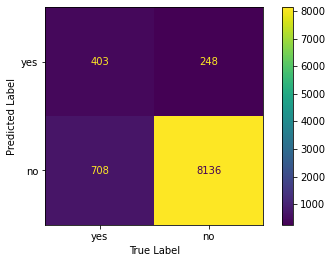

In [40]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predict,y_val,labels=[1,0]),
                       display_labels=["yes","no"]).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
plt.show()

In [41]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

24-05-2022 00:07:37 Uploading figures


In [42]:
# Feature importance
pipe.get_params()["classifier"].feature_importances_

array([0.        , 0.        , 0.00110416, 0.        , 0.        ,
       0.00134848, 0.00231335, 0.        , 0.        , 0.00226714,
       0.        , 0.        , 0.00729391, 0.        , 0.        ,
       0.03603682, 0.00117729, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04094709, 0.00221887, 0.00227049,
       0.02884251, 0.        , 0.24319231, 0.        , 0.04530092,
       0.01342532, 0.0219179 , 0.53505479, 0.00409898, 0.01118967,
       0.        ])

In [43]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

['job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_married',
 'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'contact_unknown',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

In [44]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [45]:
# merge all column names together
all_names = cat_names + num_names
all_names

['job_entrepreneur',
 'job_other',
 'job_pink-collar',
 'job_self-employed',
 'job_technician',
 'job_white-collar',
 'marital_married',
 'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
 'default_yes',
 'housing_yes',
 'loan_yes',
 'contact_telephone',
 'contact_unknown',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous']

In [46]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='DT', feature_names=all_names)

wandb: 
wandb: Plotting DT.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [ ]:
# Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_val, predict, [0,1])

In [ ]:
# Catch up the class proportions between train and validation
# wandb.sklearn.plot_class_proportions(y_train, y_val, [0,1])

In [ ]:
# Plot the importance of columns
# wandb.sklearn.plot_feature_importances(pipe.get_params()["classifier"],all_names)

In [ ]:
# Plot a brief summary of the weighted avg results (recall, precision, f1, acc)
# wandb.sklearn.plot_summary_metrics(pipe.get_params()["classifier"],
#                                    full_pipeline_preprocessing.transform(x_train),
#                                    y_train,
#                                    full_pipeline_preprocessing.transform(x_val),
#                                    y_val)

In [ ]:
# ROC curve
# predict_proba = pipe.predict_proba(x_val)
# wandb.sklearn.plot_roc(y_val, predict_proba, [0,1])

In [ ]:
# close the current run before to execute the next section
run.finish()

## 1.6 Hyperparameter Tuning

In [ ]:
# To see all parameters of a specific step of the pipeline
# pipe.named_steps['classifier'].get_params() #or
# pipe.named_steps['full_pipeline'].get_params()

In [47]:
# global seed
seed = 41

In [48]:
sweep_config = {
    # try grid or random
    "method": "random",
    "metric": {
        "name": "Accuracy",
        "goal": "maximize"
        },
    "parameters": {
        "criterion": {
            "values": ["gini","entropy"]
            },
        "splitter": {
            "values": ["random","best"]
        },
        "model": {
            "values": [0,1,2]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="decision_tree")

Create sweep with ID: 47v9nxn8
Sweep URL: https://wandb.ai/francisvalfgs/decision_tree/sweeps/47v9nxn8


In [ ]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("classifier",DecisionTreeClassifier())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"classifier__criterion": run.config.criterion})
        pipe.set_params(**{"classifier__splitter": run.config.splitter})
        pipe.set_params(**{"classifier__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        logger.info("Evaluation metrics")
        fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
        precision = precision_score(y_val, predict, zero_division=1)
        recall = recall_score(y_val, predict, zero_division=1)
        acc = accuracy_score(y_val, predict)

        logger.info("Accuracy: {}".format(acc))
        logger.info("Precision: {}".format(precision))
        logger.info("Recall: {}".format(recall))
        logger.info("F1: {}".format(fbeta))

        run.summary["Accuracy"] = acc
        run.summary["Precision"] = precision
        run.summary["Recall"] = recall
        run.summary["F1"] = fbeta

In [ ]:
wandb.agent(sweep_id, train, count=8)

## 1.7 Configure and train the best model

In [ ]:
# Note that a new run is yet synced to last sweep run
# Just to check
# run = wandb.init()

<font color="red">Important</font> to restart the colab to unlink a new experiment (run) with the last ```sweep``` experiment. 

```
Runtime >> Factory reset runtime
```
> Re-run all cells except for: ```1.4.3```, ```1.4.4```, ```1.5``` and ```1.6```. 

In [ ]:
# initiate the wandb project
# run = wandb.init(project="decision_tree", entity="mlops_ivan",job_type="train")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("classifier",DecisionTreeClassifier())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_pipeline__num_transformer__model": 2})
pipe.set_params(**{"classifier__criterion": 'entropy'})
pipe.set_params(**{"classifier__splitter": 'best'})
pipe.set_params(**{"classifier__random_state": 41})



# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
logger.info("Evaluation metrics")
fbeta = fbeta_score(y_val, predict, beta=1, zero_division=1)
precision = precision_score(y_val, predict, zero_division=1)
recall = recall_score(y_val, predict, zero_division=1)
acc = accuracy_score(y_val, predict)

logger.info("Accuracy: {}".format(acc))
logger.info("Precision: {}".format(precision))
logger.info("Recall: {}".format(recall))
logger.info("F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta

In [ ]:
# Get categorical column names
cat_names = pipe.named_steps['full_pipeline'].get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
cat_names

In [ ]:
# Get numerical column names
num_names = pipe.named_steps['full_pipeline'].get_params()["num_pipeline"][2].get_feature_names_out()
num_names

In [ ]:
# merge all column names together
all_names = cat_names + num_names
all_names

In [ ]:
# Visualize all classifier plots
# For a complete documentation please see: https://docs.wandb.ai/guides/integrations/scikit
wandb.sklearn.plot_classifier(pipe.get_params()["classifier"],
                              full_pipeline_preprocessing.transform(x_train),
                              full_pipeline_preprocessing.transform(x_val),
                              y_train,
                              y_val,
                              predict,
                              pipe.predict_proba(x_val),
                              [0,1],
                              model_name='BestModel', feature_names=all_names)

## 1.8 Export the best model

In [ ]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [ ]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)

# Save the target encoder using joblib
joblib.dump(le, artifact_encoder)

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Decision Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

In [ ]:
# Target encoder artifact
artifact = wandb.Artifact(artifact_encoder,
                          type=artifact_type,
                          description="The encoder used to encode the target variable"
                          )

logger.info("Logging target enconder artifact")
artifact.add_file(artifact_encoder)
run.log_artifact(artifact)

In [ ]:
run.finish()